In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

def get_nb_params_shape(shape):
    nb_params = 1
    for dim in shape:
        nb_params = nb_params*int(dim)
    return nb_params
def count_para():
    tot_nb_params = 0
    for trainable_variable in tf.trainable_variables():
        shape = trainable_variable.get_shape()  # e.g [D,F] or [W,H,C]
        current_nb_params = get_nb_params_shape(shape)
        tot_nb_params = tot_nb_params + current_nb_params
    print ("Total trainable params number:", tot_nb_params)

class SoftmaxLayer:
    def __init__(self, _input, _input_num, _classes_num):
        # weight
        self.W = tf.Variable(tf.zeros([_input_num, _classes_num]), dtype=tf.float32)
        # bias
        self.b = tf.Variable(tf.zeros([_classes_num,]), dtype=tf.float32)
        # output
        self.output = tf.nn.softmax(tf.matmul(_input, self.W) + self.b)
        # prediction
        self.y_pred = tf.argmax(self.output, axis=1)

    
class HiddenLayer:
    def __init__(self, _input, _input_num, _output_num, activ_func = tf.nn.sigmoid):
        # weight
        bound_val = 4.0*np.sqrt(6.0/(_input_num + _output_num))
        self.W = tf.Variable(tf.random_uniform([_input_num, _output_num], minval=-bound_val, maxval=bound_val),dtype=tf.float32, name="W")
        # bias
        self.b = tf.Variable(tf.zeros([_output_num,]), dtype=tf.float32, name="b")
        
        # output    print(mnist.test.images.shape)
        if activ_func is None:
            self.output = tf.matmul(_input, self.W) + self.b
        else:
            self.output = activ_func(tf.matmul(_input, self.W) + self.b)


class MLP:
    def __init__(self, _input, _input_num, _hidden_num, _output_num):
        # Set up the model
        last_output = _input
        last_output_num = _input_num
        
        self.hiddenlayer = []
        for i in range(len(_hidden_num)):
            self.hiddenlayer.append( HiddenLayer(last_output, _input_num = last_output_num, _output_num =_hidden_num[i]) )
            last_output = self.hiddenlayer[i].output
            last_output_num = _hidden_num[i]

        
        self.outputlayer = SoftmaxLayer(last_output, _input_num=last_output_num, _classes_num=_output_num)
        
        # prediction
        self.y_pred = self.outputlayer.y_pred


    def cross_entropy_loss(self, y):
        return -tf.reduce_mean(tf.reduce_sum(y * tf.log(self.outputlayer.output), axis=1))

    def accuracy(self, y):
        correct_pred = tf.equal(self.outputlayer.y_pred, tf.argmax(y, axis=1))
        return tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [2]:
if __name__ == "__main__":
    # load mnist dataset
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
    
    # define training param
    epochs_num = 100
    batch_size = 100
    display_step = 10
    batch_num = int(mnist.train.num_examples / batch_size)
    
    
    # define input and output placehoders
    x = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    # create mlp model
    multiclass_logistic_regressor = MLP(_input=x, _input_num=784, _hidden_num=[500,250], _output_num=10)
    # get loss
    with tf.name_scope('loss'):
        loss = multiclass_logistic_regressor.cross_entropy_loss(y_)
    #tf.summary.scalar('loss', loss)
    # accuracy
    with tf.name_scope('accuracy'):
        accuracy = multiclass_logistic_regressor.accuracy(y_)
    #tf.summary.scalar('accuracy', accuracy)
    
    predictor = multiclass_logistic_regressor.y_pred
    


    #merged = tf.summary.merge_all()
    #train_writer = tf.summary.FileWriter('/train',sess.graph)
    #train_writer = tf.summary.FileWriter('./log/train',sess.graph)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


# (a) GradientDescentOptimizer

Total trainable params number: 520260
Training, step_size =  0.0001
Epoch 0: loss: 2.2993230308185924, validation accuacy: 0.11259999871253967
Epoch 10: loss: 2.245841017636386, validation accuacy: 0.26739999651908875


KeyboardInterrupt: 

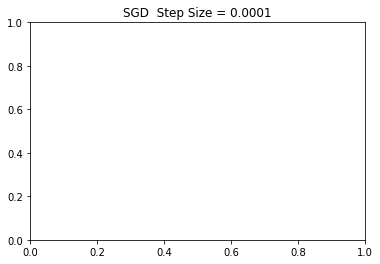

In [3]:
    for lr in [0.0001, 0.001, 0.01, 0.1, ]: 
        train_op = tf.train.GradientDescentOptimizer(learning_rate=lr).minimize(loss)
        init = tf.global_variables_initializer()
        count_para()
        print("Training, step_size = ", lr)
        with tf.Session() as sess:
            sess.run(init)
            
            fig = plt.figure() 
            plt.title('SGD  Step Size = '+ str(lr))
            x_axis = []
            y_axis = []
            it = 0
            
            for epoch in range(epochs_num):
                avg_loss = 0.0
            
                for i in range(batch_num):
                    x_batch, y_batch = mnist.train.next_batch(batch_size)
                    sess.run(train_op, feed_dict={x: x_batch, y_: y_batch})
                    this_loss = sess.run(loss, feed_dict={x: x_batch, y_: y_batch}) 
                    
                    avg_loss += this_loss / batch_num
                 
                    x_axis.append(it)
                    y_axis.append(this_loss)
                    it+=1

                if epoch % display_step == 0:
                    val_acc = sess.run(accuracy, feed_dict={x: mnist.validation.images,
                                                           y_: mnist.validation.labels})
                    print("Epoch {0}: loss: {1}, validation accuacy: {2}".format(epoch, avg_loss, val_acc))
           
            plt.plot(x_axis, y_axis)
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()
                    
            print("Test, step_size = ", lr)
            test_acc = sess.run(accuracy, feed_dict={x: mnist.test.images,y_: mnist.test.labels})
            print("Test: accuacy: {0}".format(test_acc))

            print("")

    



        
        

# （b) MomentumOptimizer

In [ ]:
    for lr in [0.01, 0.1]:
        for momentum in [0.5, 0.9, 0.99]:
            train_op = tf.train.MomentumOptimizer(learning_rate=lr, momentum=momentum).minimize(loss)
            init = tf.global_variables_initializer()
            print("Training, step_size = ", lr, " momentum = ", momentum)
            with tf.Session() as sess:
                sess.run(init)
            
                fig = plt.figure() 
                fig.suptitle('step size = '+ str(lr)+' momentum = '+str(momentum))
                x_axis = []
                y_axis = []
                it = 0
            
                for epoch in range(epochs_num):
                    avg_loss = 0.0
            
                    for i in range(batch_num):
                        x_batch, y_batch = mnist.train.next_batch(batch_size)
                        sess.run(train_op, feed_dict={x: x_batch, y_: y_batch})
                        this_loss = sess.run(loss, feed_dict={x: x_batch, y_: y_batch}) 
                    
                        avg_loss += this_loss / batch_num
                 
                        x_axis.append(it)
                        y_axis.append(this_loss)
                        it+=1

                    if epoch % display_step == 0:
                        val_acc = sess.run(accuracy, feed_dict={x: mnist.validation.images,
                                                           y_: mnist.validation.labels})
                        print("Epoch {0}: loss: {1}, validation accuacy: {2}".format(epoch, avg_loss, val_acc))
           
                plt.plot(x_axis, y_axis)
                plt.show()
                    
                print("Testing, step_size = ", lr, " momentum = ", momentum)
                test_acc = sess.run(accuracy, feed_dict={x: mnist.test.images,y_: mnist.test.labels})
                print("Test: accuacy: {0}".format(test_acc))

                print("")

# (c) & (d) AdamOptimizer 

In [ ]:
    for lr in [0.0001,0.0005, 0.001, 0.002, 0.01, 0.05]: 
        train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
        init = tf.global_variables_initializer()
        print("Training, step_size = ", lr)
        with tf.Session() as sess:
            sess.run(init)
            
            fig = plt.figure() 
            plt.title('Adam Optimizer  Step Size = '+ str(lr))

            x_axis = []
            y_axis = []
            it = 0
            
            for epoch in range(epochs_num):
                avg_loss = 0.0
            
                for i in range(batch_num):
                    x_batch, y_batch = mnist.train.next_batch(batch_size)
                    sess.run(train_op, feed_dict={x: x_batch, y_: y_batch})
                    this_loss = sess.run(loss, feed_dict={x: x_batch, y_: y_batch}) 
                    
                    avg_loss += this_loss / batch_num
                 
                    x_axis.append(it)
                    y_axis.append(this_loss)
                    it+=1

                if epoch % display_step == 0:
                    val_acc = sess.run(accuracy, feed_dict={x: mnist.validation.images,
                                                           y_: mnist.validation.labels})
                    print("Epoch {0}: loss: {1}, validation accuacy: {2}".format(epoch, avg_loss, val_acc))
           
            plt.plot(x_axis, y_axis)
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()
                    
            print("Test, step_size = ", lr)
            test_acc = sess.run(accuracy, feed_dict={x: mnist.test.images,y_: mnist.test.labels})
            print("Test: accuacy: {0}".format(test_acc))

            print("")